In [2]:
from binance import Client
import pandas as pd
import numpy as np
import mplfinance as mpl
import mercury as mr
from datetime import date
import os
api_key = os.environ.get('api_key')
secret_key = os.environ.get('secret_key')


In [2]:
client = Client(api_key, secret_key, tld='us')
app = mr.App(title="Crypto charts", description="Report financial data for selected cryptocurrency.")

mercury.App

In [3]:
tickers = client.get_all_tickers()
ticker_df = pd.DataFrame(tickers)
ticker_df['symbol'] = ticker_df['symbol'].astype('string')
ticker_array = np.array(ticker_df['symbol'])

In [4]:
crypto_input = mr.Text(value="BTCUSDT", label="Enter Cryptocurrency:", rows=1)
symbol = crypto_input.value.upper()

interval_select = mr.Select(value="15 Minutes", 
                    choices=['1 Minute', '3 Minutes', '5 Minutes', '15 Minutes', '1 Hour', '4 Hours', '12 Hours', 'Day', 'Week'], 
                    label="Choose your interval")


mercury.Text

mercury.Select

# Basic info ✨

In [5]:
time_res = client.get_server_time()
current_time = time_res['serverTime']
formated_server_time = pd.to_datetime(time_res['serverTime']/1000, unit='s')
formated_server_time = formated_server_time.strftime("%H:%M")

In [6]:
mr.Md(f"### Server time: **{formated_server_time}**")

### Server time: **09:31**

In [15]:
interval = Client.KLINE_INTERVAL_1DAY
interval_date = str(date.today())

if interval_select.value == '1 Minute':
    interval = Client.KLINE_INTERVAL_1MINUTE
    time_ago = mr.Slider(value=180, min=60, max=360, label="Minutes ago", step=1)
    interval_date = str(time_ago.value) + ' minutes ago'

elif interval_select.value == '3 Minutes':
    interval = Client.KLINE_INTERVAL_3MINUTE
    time_ago = mr.Slider(value=360, min=180, max=720, label="Minutes ago", step=3)
    interval_date = str(time_ago.value) + ' minutes ago'

elif interval_select.value == '5 Minutes':
    interval = Client.KLINE_INTERVAL_5MINUTE
    time_ago = mr.Slider(value=480, min=360, max=720, label="Minutes ago", step=5)
    interval_date = str(time_ago.value) + ' minutes ago'

elif interval_select.value == '15 Minutes':
    interval = Client.KLINE_INTERVAL_15MINUTE
    time_ago = mr.Slider(value=24, min=12, max=168, label="Hours ago", step=1)
    interval_date = str(time_ago.value) + ' hours ago'

elif interval_select.value == '1 Hour':
    interval = Client.KLINE_INTERVAL_1HOUR
    time_ago = mr.Slider(value=120, min=12, max=240, label="Hours ago", step=1)
    interval_date = str(time_ago.value) + ' hours ago'

elif interval_select.value == '4 Hours':
    interval = Client.KLINE_INTERVAL_4HOUR
    time_ago = mr.Slider(value=120, min=48, max=480, label="Hours ago", step=4)
    interval_date = str(time_ago.value) + ' hours ago'
        
elif interval_select.value == '12 Hours':
    interval = Client.KLINE_INTERVAL_12HOUR
    time_ago = mr.Slider(value=50, min=10, max=100, label="Days ago", step=1)
    interval_date = str(time_ago.value) + ' days ago'
    
elif interval_select.value == 'Day':
    interval = Client.KLINE_INTERVAL_1DAY
    time_ago = mr.Slider(value=50, min=10, max=200, label="Days ago", step=5)
    interval_date = str(time_ago.value) + ' days ago'

elif interval_select.value == 'Week':
    interval = Client.KLINE_INTERVAL_1WEEK
    time_ago = mr.Slider(value=50, min=5, max=200, label="Weeks ago", step=5)
    interval_date = str(time_ago.value) + ' weeks ago'



mercury.Slider

In [16]:
volume_bool = mr.Checkbox(value=True, label="Volume")

mercury.Checkbox

In [9]:
try:
    error = False
    if not symbol:
        error = True
        raise ValueError("Don't leave blank space")
    elif symbol not in ticker_array:
        error = True
        raise ValueError("Somethink gone wrong. Check your entry.")
    
    hist = client.get_historical_klines(symbol, interval, interval_date)

    histdf = pd.DataFrame(hist)

    histdf = histdf.drop(columns=[6, 7, 8, 9, 10, 11])

    histdf.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    histdf['Date'] = pd.to_datetime(histdf['Date']/1000, unit='s')

    histdf.set_index(histdf['Date'], inplace=True)

    histdf = histdf.drop(columns=['Date'])

    numeric_cols=['Open', 'High', 'Low', 'Close', 'Volume']
    histdf[numeric_cols] = histdf[numeric_cols].apply(pd.to_numeric, axis=1)

    mean_price = round((histdf.Open.mean()+histdf.Close.mean())/2,1)

except ValueError as e:
    mr.Md(f"### **{e}**")

In [10]:
if not error:
    mr.Md(f"#<center>**{symbol}**</center>")

#<center>**BTCUSDT**</center>

In [11]:
mr.NumberBox(data=histdf['Close'].iloc[-1], 
            title=f"Current close price",
            background_color="#FCEADE")


In [12]:
mr.NumberBox([
        mr.NumberBox(data=histdf.High.max().round(1), title=f"Highest price", background_color="#FEF5EF"),
        mr.NumberBox(data=mean_price, title=f"Mean price", background_color="#FEF5EF"),
        mr.NumberBox(data=histdf.Low.min().round(1), title=f"Lowest price", background_color="#FEF5EF")
        ])


In [13]:
if not error:
    mr.Md("# 📈Chart📈")

# 📈Chart📈

mercury.Select

mercury.Select

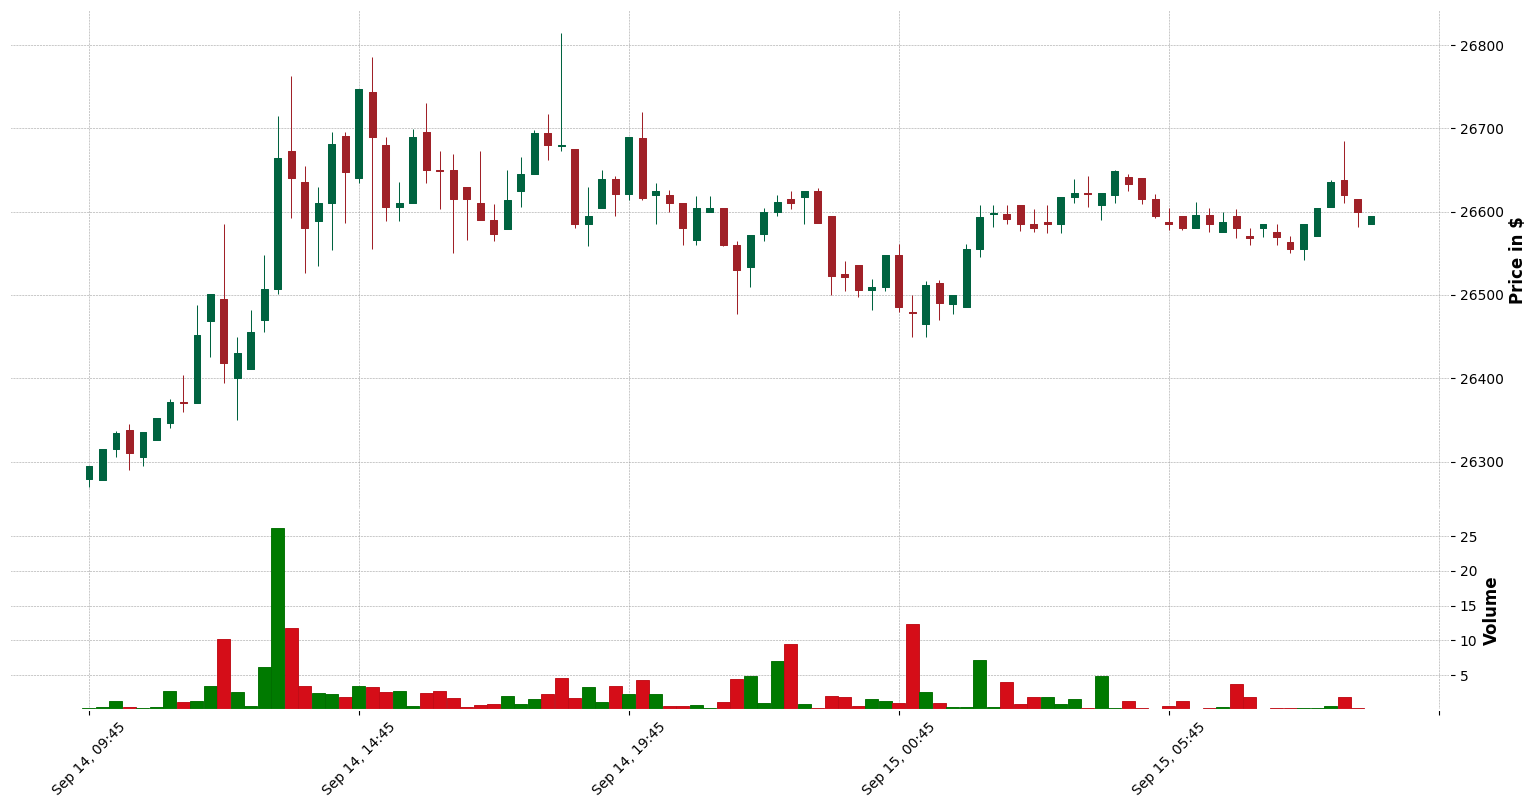

In [14]:
plot_type = mr.Select(value="candle", choices=['candle', 'line'], label="Chart type:")
candle_style = 'charles'
color = 'blue'

if plot_type.value == 'line':
    color_select = mr.Select(value="blue", choices=['blue', 'red', 'green', 'black', 'purple'], label="Line color:")
    color = color_select.value

else:
    style_select = mr.Select(value='charles', choices=['classic', 'default', 'charles', 'binance', 'blueskies', 'brasil', 'checkers', 'kenan', 'ibd', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'yahoo'], label='Candle style:')
    candle_style = style_select.value

if not error:
    mpl.plot(histdf, type=plot_type.value, volume=volume_bool.value, linecolor=color, ylabel='Price in $', style=candle_style, figsize=(20,10), warn_too_much_data=1000)